In [1]:
!pip install einops
!pip install -U tensorflow-text
!pip install googletrans==4.0.0-rc1
!pip install datasets transformers[sentencepiece] sacrebleu -q
!pip install pyvi

  Obtaining dependency information for einops from https://files.pythonhosted.org/packages/29/0b/2d1c0ebfd092e25935b86509a9a817159212d82aa43d7fb07eca4eeff2c2/einops-0.7.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 966.8 kB/s eta 0:00:00
  Obtaining dependency information for tensorflow-text from https://files.pythonhosted.org/packages/70/12/91be80b24a403593f9dacddabd6f7ea110373a1831f575ad2d34fe7d4f7e/tensorflow_text-2.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for tensorflow<2.16,>=2.15.0 from https://files.pythonhosted.org/packages/e3/ba/aa8a76eff5c20761b0361a5b4c9fccb8742c29a82adba7a8ad8ae819984e/tensorflow-2.15.0.post1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for ml-dtypes~=0.2.0 from https://files.pythonhosted.org/packages/d1/1d/d5cf76e5e40f69dbd273036e3172ae4a614577cb141673427b80cac948df/ml_dtypes-0.2.0-cp310-cp310-m

# Import library 

In [2]:
import numpy as np
import pandas as pd
import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

from datasets import load_dataset

2023-12-10 09:11:22.483643: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 09:11:22.483710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 09:11:22.485343: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# TEXT PREPROCESSING

In [3]:
raw_datasets = load_dataset("mt_eng_vietnamese", 'iwslt2015-vi-en')

Generating train split:   0%|          | 0/133318 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1269 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1269 [00:00<?, ? examples/s]

Dataset mt_eng_vietnamese downloaded and prepared to /root/.cache/huggingface/datasets/mt_eng_vietnamese/iwslt2015-vi-en/1.0.0/53add551a01e9874588066f89d42925f9fad43db347199dad00f7e4b0c905a71. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
max_input_length = 128
max_target_length = 128

source_lang = "en"
target_lang = "vi"

def preprocess_function(examples):
    inputs = [ex[source_lang] for ex in examples["translation"]]
    targets = [ex[target_lang] for ex in examples["translation"]]



    return inputs, targets

In [5]:
context_raw, target_raw = preprocess_function(raw_datasets["train"])
print(context_raw[0])

Rachel Pike : The science behind a climate headline


In [6]:
print(target_raw[0])

Khoa học đằng sau một tiêu đề về khí hậu


In [7]:
len(context_raw), len(target_raw)



(133318, 133318)

In [8]:
context_raw = [t.replace('&apos;m', 'am')
               .replace('&apos;re', 'are')
               .replace('&apos;s', 'is')
               .replace('&apos;ve', 'have')
               .replace('&apos;ll', 'will')
               .replace('don &apos;t', 'do not')
               .replace('didn &apos;t', 'did not')
               .replace('Don &apos;t', 'Do not')
               .replace('Didn &apos;t', 'Did not')
               for t in context_raw]

In [9]:
target_raw = [t.replace('đ', 'd')
              .replace('Đ', 'D')
              .replace("&#93", "")
              .replace("&#91", "")
              .replace(';', ',')
              for t in target_raw]

In [10]:

example_text = tf.constant(target_raw[0])

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFD').numpy())

b'Khoa h\xe1\xbb\x8dc d\xe1\xba\xb1ng sau m\xe1\xbb\x99t ti\xc3\xaau d\xe1\xbb\x81 v\xe1\xbb\x81 kh\xc3\xad h\xe1\xba\xadu'
b'Khoa ho\xcc\xa3c da\xcc\x86\xcc\x80ng sau mo\xcc\xa3\xcc\x82t tie\xcc\x82u de\xcc\x82\xcc\x80 ve\xcc\x82\xcc\x80 khi\xcc\x81 ha\xcc\xa3\xcc\x82u'


In [11]:
def tf_lower_and_split_punct(text):
    # Normalize Vietnamese text.
    text = tf_text.normalize_utf8(text, 'NFD')  # 'NFD' is suitable for Vietnamese text
    text = tf.strings.lower(text)
    # Keep space, a to z, and select Vietnamese punctuation.
    text = tf.strings.regex_replace(text, '[^ & # $ a-z.?!\\p{P}]+', '')
    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, '([.?!])', r' \1 ')
    # Strip whitespace.
    text = tf.strings.strip(text)

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text


In [12]:
from sklearn.model_selection import train_test_split

BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64
# Tạo mảng indices từ 0 đến len(context_raw)
train_indices = int(len(context_raw)*0.8)



# Tạo tập huấn luyện và tập kiểm tra từ các indices tương ứng
train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[:train_indices], target_raw[:train_indices]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[train_indices:], target_raw[train_indices:]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [13]:
print(len(train_raw))
print(len(val_raw))

1667
417


In [14]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'I think that it is important for us to remember that we need to keep pushing forward on the endeavor of the design of the heart .'
 b'So what is going on ?'
 b'It had a driver and a passenger , and after the car had passed the judge by , the passenger extended his hand , pointed it back to the judge as the car continued on , just as the teenagers had described it , right ?'
 b'And I said , &quot; Okay , that is interesting . &quot;'
 b'This got us very excited .'], shape=(5,), dtype=string)

tf.Tensor(
[b'T\xc3\xb4i ngh\xc4\xa9 r\xe1\xba\xb1ng di\xe1\xbb\x81u n\xc3\xa0y r\xe1\xba\xa5t quan tr\xe1\xbb\x8dng d\xe1\xbb\x83 ch\xc3\xbang ta nh\xe1\xbb\x9b r\xe1\xba\xb1ng ch\xc3\xbang ta c\xe1\xba\xa7n ti\xe1\xba\xbfp t\xe1\xbb\xa5c n\xe1\xbb\x97 l\xe1\xbb\xb1c h\xc6\xa1n n\xe1\xbb\xafa d\xe1\xbb\x83 ho\xc3\xa0n thi\xe1\xbb\x87n tr\xc3\xa1i tim m\xc3\xacnh .'
 b'V\xe1\xba\xady l\xc3\xa0 sao ?'
 b'Trong xe c\xc3\xb3 m\xe1\xbb\x99t t\xc3\xa0i x\xe1\xba\xbf v\xc3\xa0 m\xe1\xbb\x99

In [15]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

Khoa học dằng sau một tiêu dề về khí hậu
[START] khoa hoc dang sau mot tieu de ve khi hau [END]


In [16]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [17]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', ',', '.', '[START]', '[END]', 'the', 'and', 'to', 'is']

In [18]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', ',', '.', 'toi', 'va', 'co', 'la']

In [19]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[4, 13, 72, 12, 15, 9, 183, 24, 84, 8, 380, 12, 17, 124, 8, 375, 2674, 802,
  31, 6, 1, 10, 6, 262, 10, 6, 421, 3, 5]                                   ,
 [4, 20, 27, 9, 64, 31, 34, 5],
 [4, 15, 75, 11, 1993, 7, 11, 2951, 2, 7, 159, 6, 397, 75, 1477, 6, 2368,
  60, 2, 6, 2951, 4260, 118, 369, 2, 4014, 15, 120, 8, 6, 2368, 38, 6, 397,
  2491, 31, 2, 51, 38, 6, 2798, 75, 1885, 15, 2, 107, 34, 5]               ]>

In [20]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] i think that it is important for us to remember that we need to keep pushing forward on the [UNK] of the design of the heart . [END]'

Text(0.5, 1.0, 'Mask')

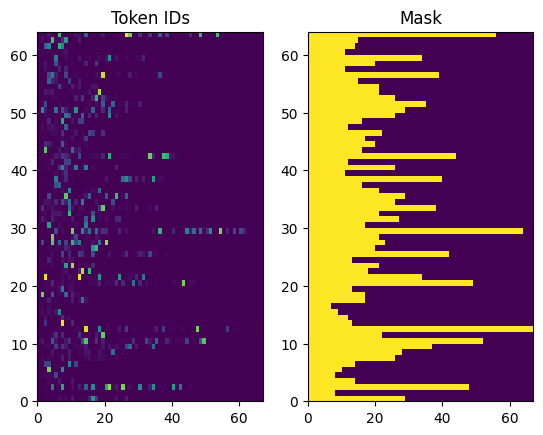

In [21]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

In [22]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [23]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy())
  print()
  print(ex_tar_in[0, :10].numpy())
  print(ex_tar_out[0, :10].numpy())

[   4  166 1124  564    6  267    3    5    0    0]

[  2  49  20 101   8  64 184   5   0   0]
[ 49  20 101   8  64 184   5   3   0   0]


In [24]:
class ShapeChecker:
  def __init__(self):
    # Keep a list of shapes seen during one forward pass
    self.shapes = []

  def __call__(self, x, names, broadcast=False):
    if isinstance(x, (list, tuple)):
      # If the input is a list or tuple, check each element.
      for xi, name in zip(x, names):
        self(xi, name, broadcast)
      return

    # If the input is a tensor, check its shape.
    shape = tuple(x.shape)

    # If the input is not a scalar, add to the shapes list.
    if shape:
      self.shapes.append((names, shape))

    # For broadcasting, the shape must be at least one-dimensional.
    if broadcast and len(shape) > 1:
      self.shapes.append(('broadcast with '+names, shape))

  def assert_same_shape(self):
    if not self.shapes:
      return

    names, shape = self.shapes[0]
    for other_names, other_shape in self.shapes[1:]:
      if shape != other_shape:
        raise AssertionError(
            f'For {names} and {other_names}, expected {shape} but got '
            f'{other_shape}.')
    self.shapes = []

  def __enter__(self):
    return self

  def __exit__(self, *args):
    self.assert_same_shape()


# ENCODER

In [25]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [26]:
UNITS = 256
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 71)
Encoder output, shape (batch, s, units): (64, 71, 256)


# ATTENTION LAYER

In [27]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()

    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')

    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [28]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 71, 256)
Target sequence, shape (batch, t, units): (64, 73, 256)
Attention result, shape (batch, t, units): (64, 73, 256)
Attention weights, shape (batch, t, s):    (64, 73, 71)


In [29]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.        , 1.        , 1.        , 1.        , 0.99999994,
       1.        , 1.        , 1.        , 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994], dtype=float32)

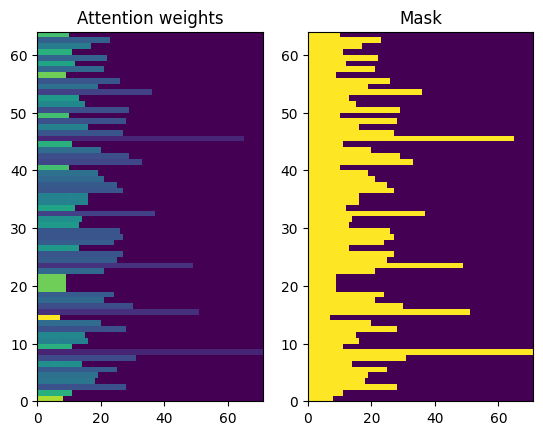

In [30]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');

# DECODER

In [31]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [32]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [33]:
decoder = Decoder(target_text_processor, UNITS)
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 71, 256)
input target tokens shape: (batch, t) (64, 73)
logits shape shape: (batch, target_vocabulary_size) (64, 73, 5000)


In [34]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [35]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [36]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True)

  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  return next_token, done, state

In [37]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'sean walter amjad shannon cuong vaclav science yeah xan dollar',
       b'tom domain empire len-- yuyu gi khz francis kaplan tesla',
       b'rosalie cay allen palestine mccallum delta madison men kit youtube'],
      dtype=object)

# TRANSLATOR

In [38]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy.
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [39]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 71)
Target tokens, shape: (batch, t) (64, 73)
logits, shape: (batch, t, target_vocabulary_size) (64, 73, 5000)


In [40]:
model.summary()

Model: "translator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  2069504   
                                                                 
 decoder_1 (Decoder)         multiple                  3223432   
                                                                 
Total params: 5292936 (20.19 MB)
Trainable params: 5292936 (20.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [41]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [42]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [43]:
model.compile(optimizer='adam',
              loss=masked_loss,
              metrics=[masked_acc, masked_loss])

In [44]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(), "expected_acc": 1/vocab_size}

{'expected_loss': 8.517193, 'expected_acc': 0.0002}

In [45]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 24s 831ms/step - loss: 8.5304 - masked_acc: 1.5258e-04 - masked_loss: 8.5304


{'loss': 8.530404090881348,
 'masked_acc': 0.00015257534687407315,
 'masked_loss': 8.530404090881348}

## Train

In [46]:
history = model.fit(
    train_ds.repeat(),
    epochs=30,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
)

Epoch 1/30
100/100 [==============================] - 149s 1s/step - loss: 5.7058 - masked_acc: 0.0815 - masked_loss: 5.7058 - val_loss: 5.1374 - val_masked_acc: 0.1405 - val_masked_loss: 5.1374
Epoch 2/30
100/100 [==============================] - 136s 1s/step - loss: 4.7255 - masked_acc: 0.1910 - masked_loss: 4.7255 - val_loss: 4.5651 - val_masked_acc: 0.2032 - val_masked_loss: 4.5651
Epoch 3/30
100/100 [==============================] - 131s 1s/step - loss: 4.3351 - masked_acc: 0.2343 - masked_loss: 4.3351 - val_loss: 4.2829 - val_masked_acc: 0.2406 - val_masked_loss: 4.2829
Epoch 4/30
100/100 [==============================] - 144s 1s/step - loss: 4.1347 - masked_acc: 0.2590 - masked_loss: 4.1347 - val_loss: 4.1075 - val_masked_acc: 0.2642 - val_masked_loss: 4.1075
Epoch 5/30
100/100 [==============================] - 144s 1s/step - loss: 3.9255 - masked_acc: 0.2892 - masked_loss: 3.9255 - val_loss: 3.9725 - val_masked_acc: 0.2841 - val_masked_loss: 3.9725
Epoch 6/30
100/100 [=====

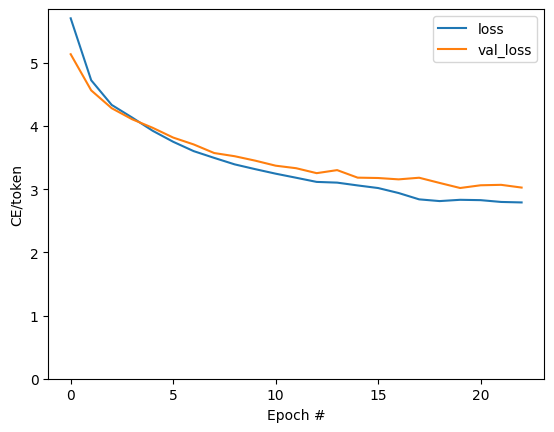

In [47]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()
plt.show()

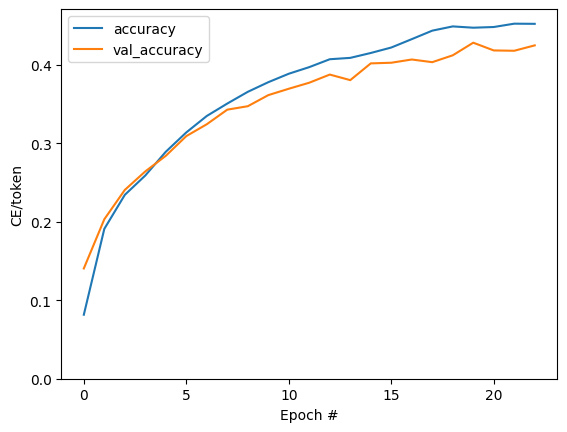

In [48]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()
plt.show()

In [49]:
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)

    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [50]:
result = model.translate(['what is this?'])
result[0].numpy().decode()

'dieu nay ? '

In [51]:
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)


  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

  plt.show()

/tmp/ipykernel_26/1333339166.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/tmp/ipykernel_26/1333339166.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


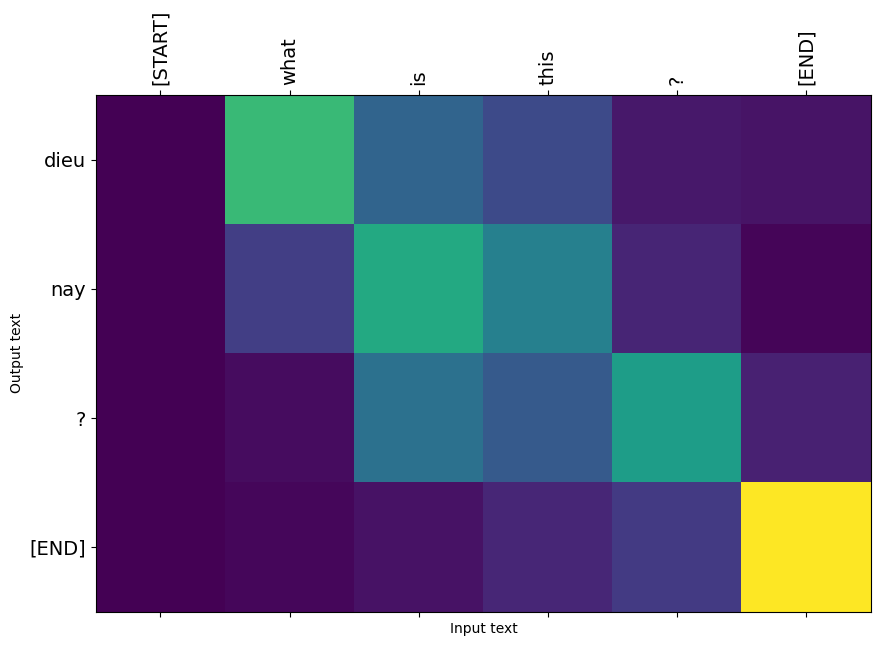

In [52]:
model.plot_attention('what is this?')

/tmp/ipykernel_26/1333339166.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/tmp/ipykernel_26/1333339166.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


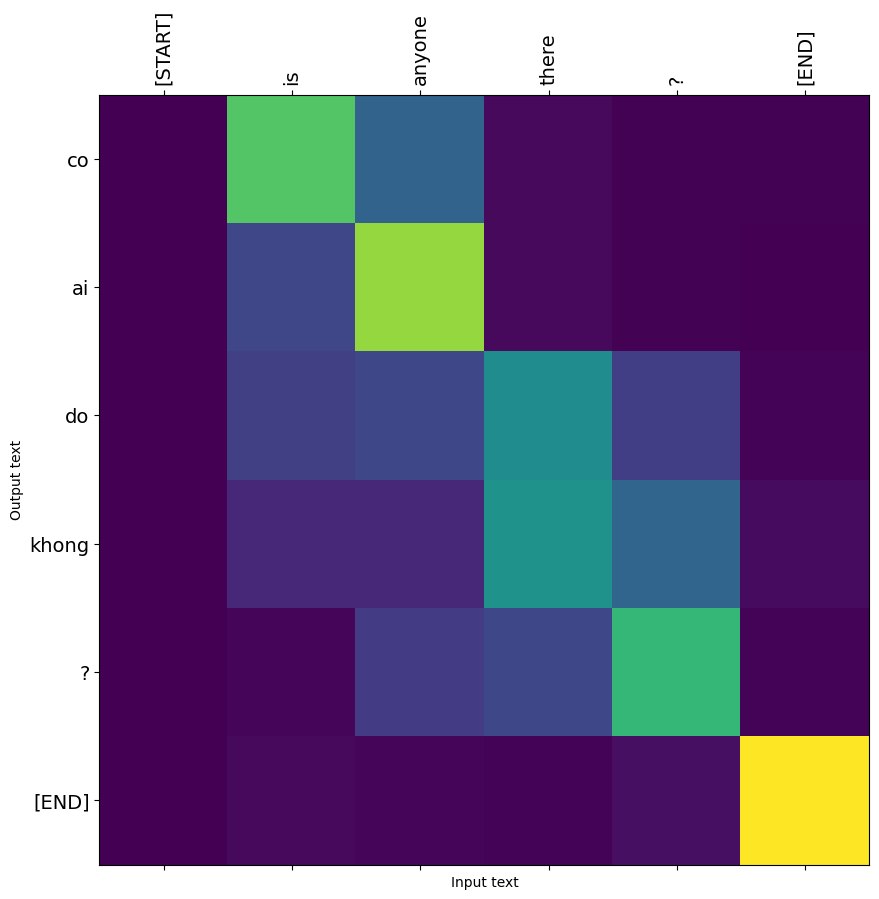

CPU times: user 929 ms, sys: 315 ms, total: 1.24 s
Wall time: 661 ms


In [53]:
%%time
model.plot_attention('Is anyone there?')

In [54]:
long_text = context_raw[train_indices]

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(target_raw[train_indices])))

Expected output:
 Và trong câu chuyện săn cá voi còn cả mức dộ kích thích nữa .


/tmp/ipykernel_26/1333339166.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/tmp/ipykernel_26/1333339166.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


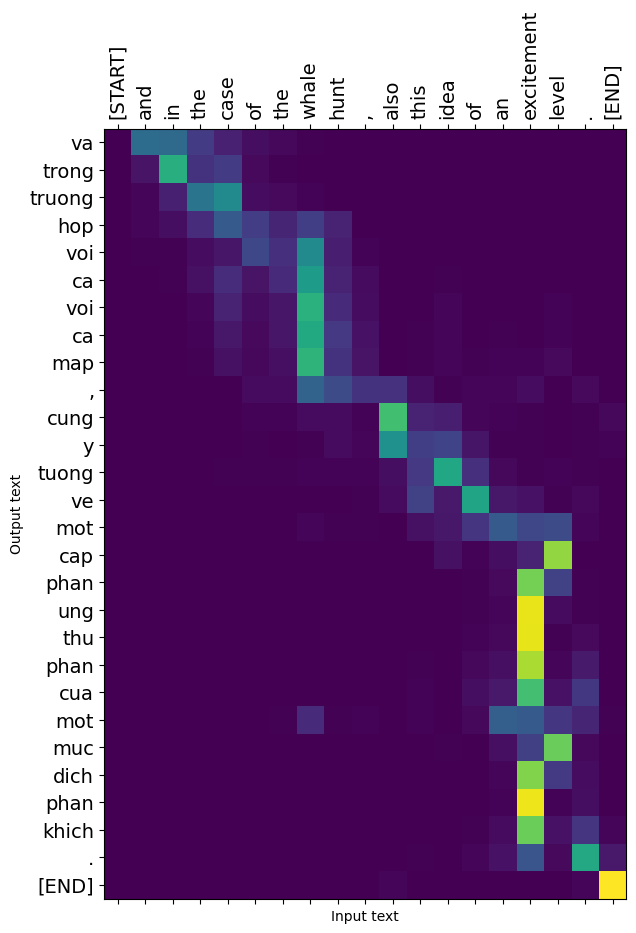

In [55]:
model.plot_attention(long_text)

In [56]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [57]:
export = Export(model)

In [58]:
%%time
tf.saved_model.save(export, 'translator',
                    signatures={'serving_default': export.translate})

CPU times: user 1min 24s, sys: 1.37 s, total: 1min 26s
Wall time: 1min 26s


In [59]:
!sudo apt install tesseract-ocr
!sudo apt install tesseract-ocr-eng

!pip install pytesseract




tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 46 not upgraded.



tesseract-ocr-eng is already the newest version (1:4.00~git30-7274cfa-1.1).
tesseract-ocr-eng set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 46 not upgraded.


In [60]:
# Import thư viện và thiết lập đường dẫn Tesseract OCR
from PIL import Image
import pytesseract
pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'

In [61]:
# Hàm nhận dạng văn bản từ hình ảnh
def detect_text(image_path):
    # Mở hình ảnh từ đường dẫn
    image = Image.open(image_path)

    # Nhận dạng văn bản bằng Tesseract OCR
    text = pytesseract.image_to_string(image)

    return text

# Gọi hàm detect_text với đường dẫn của hình ảnh cần nhận dạng
detect_text("/kaggle/input/images-test/anh1.jpg")

'He like learning English\nHe goes to school\n\nShe is a beautiful girl}\n\x0c'

In [62]:
sentence = detect_text("/kaggle/input/images-test/anh1.jpg")
sentences = [sentence.strip() for sentence in sentence.split('\n') if sentence.strip()]

# In kết quả
print()
sentences[-1] = sentences[-1].replace('}', '')
sentences

['He like learning English', 'He goes to school', 'She is a beautiful girl']

In [63]:
%%time
inputs =[
    'He is very cold.',
    'this is my life .',
    'his room is a mess .',
    "Don't you think so?",
    "He won't like this.",
    "He like learning English."
]
inputs = sentences

reloaded = tf.saved_model.load('translator')
result = reloaded.translate(tf.constant(sentences))
r = []
for i in result:
  y = i.numpy().decode()
  print(y)
  r.append(y)

from pyvi import ViUtils
r = [ViUtils.add_accents(i) for i in r]

W0000 00:00:1702202880.280537      26 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
W0000 00:00:1702202880.281478      26 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environ

anh ay thich hoc tieng anh                                            
anh ta di den truong                                             
co ay la co gai                                             
CPU times: user 56.2 s, sys: 1.63 s, total: 57.8 s
Wall time: 56.1 s


In [64]:
%%time
from googletrans import Translator

# Tạo đối tượng Translator
translator = Translator()

# Dịch từ tiếng Anh sang tiếng Việt
trans = []
for i in inputs:
  res = translator.translate(i, src="en", dest="vi")
  trans.append(res.text)



CPU times: user 117 ms, sys: 6.18 ms, total: 123 ms
Wall time: 3.19 s


In [65]:
%%time

# Tạo một Series từ mỗi danh sách
series1 = pd.Series(r, name='seq2seq')
series2 = pd.Series(trans, name='google_translate')



# Tạo DataFrame từ kết quả so sánh
df = pd.DataFrame({'input': inputs,'seq2seq': series1, 'google_translate': series2})

# In ra DataFrame
df

CPU times: user 2.31 ms, sys: 32 µs, total: 2.34 ms
Wall time: 9.07 ms


,input,seq2seq,google_translate
0,He like learning English,Anh ấy thích học tiếng Anh ...,Anh ấy thích học tiếng Anh
1,He goes to school,Ánh ta đi đến trường ...,Anh ấy đi đến trường
2,She is a beautiful girl,Có ấy là cô gái ...,Cô là một cô gái xinh đẹp
